In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

# Chicago geo-coding

Quickly explore how the `block` and coordinates match up.

- 2001 data is geo-coded differently, so we ignore it for now...

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tilemapbase
import lzma, collections
import open_cp.logger
open_cp.logger.log_to_true_stdout("impute")
import impute.chicago
import impute.geometry
import impute.tiger_lines
import pandas as pd
import numpy as np
import shapely.geometry
import geopandas as gpd
import scipy.spatial
import descartes
import pyproj
proj = pyproj.Proj({"init":"epsg:2790"})

In [3]:
datadir = os.path.join("/media", "disk", "Data")
#datadir = os.path.join("..", "..", "..", "..", "Data")
filename = os.path.join(datadir, "chicago_all.csv.xz")

def gen():
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from impute.chicago.load_only_with_point(f)
        
next(gen())

Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427))

## Load data and plot

In [4]:
data = [(row.address, row.point) for row in gen()
        if row.datetime.year > 2001]

In [5]:
frame = pd.DataFrame({"block" : [d[0] for d in data],
        "x" : [d[1][0] for d in data],
        "y" : [d[1][1] for d in data]
    })
frame.head()

,block,x,y
0,108XX S AVENUE G,-87.531656,41.698387
1,060XX S WOLCOTT AVE,-87.671612,41.784308
2,014XX E 74TH ST,-87.590370,41.760551
3,006XX E 90TH PL,-87.608883,41.730199
4,040XX N KIMBALL AVE,-87.712927,41.954403


In [ ]:
def plot_block(ax, block, size=0.00001, scatter_all=False):
    data = frame[frame.block == block]
    xcs, ycs = [], []
    for x, y in zip(data.x, data.y):
        x, y = tilemapbase.project(x, y)
        xcs.append(x)
        ycs.append(y)

    x, y = np.mean(xcs), np.mean(ycs)
    ex = tilemapbase.Extent.from_centre(x, y, xsize=size)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
    plotter.plot(ax)
    if scatter_all:
        xcs, ycs = [], []
        for x, y in zip(frame.x, frame.y):
            x, y = tilemapbase.project(x, y)
            xcs.append(x)
            ycs.append(y)
    ax.scatter(xcs, ycs, marker="x", color="black", linewidth=1)

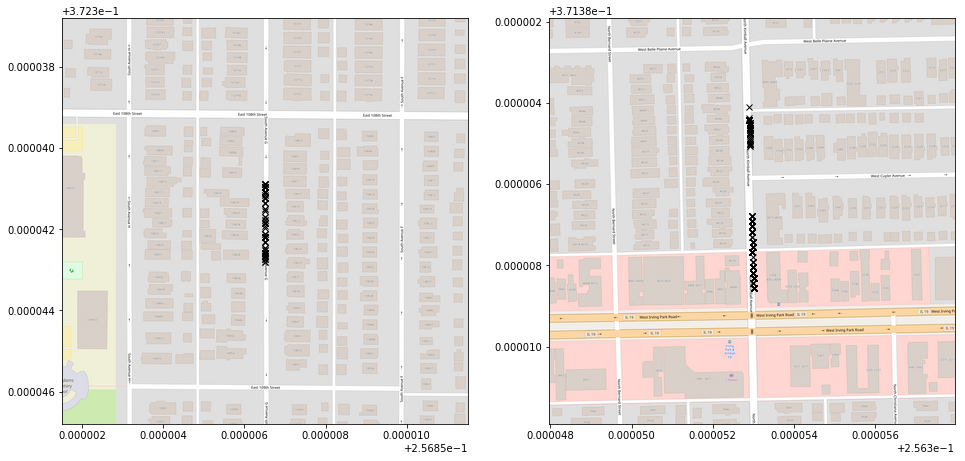

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

for ax, block in zip(axes, ["108XX S AVENUE G", "040XX N KIMBALL AVE"]):
    plot_block(ax, block)

The examples above are common: the points either bunch together in the centre of the block, or they bunch together in a number of different clusters for the block (somehow influenced by the presence of "major" side roads).  There are occasionally outliers.

# Things which are hard to explain

Why does `054XX S LAFLIN ST` get split into two parts, but not the streets to the east and west?  Why does West 54th street (east/west street at the top) have two clumps to the left, and only one clump to the right?

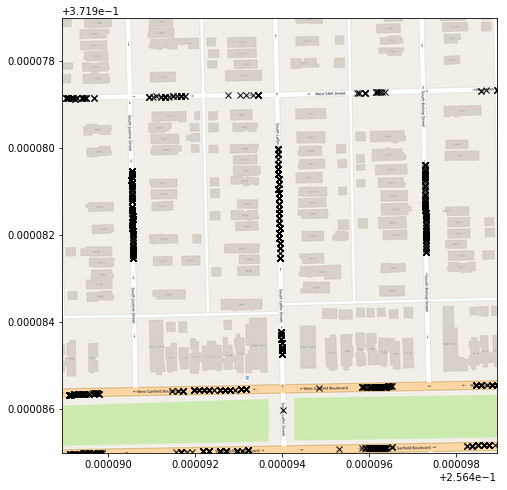

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
plot_block(ax, "054XX S LAFLIN ST", scatter_all=True)

Why the strange outliers???

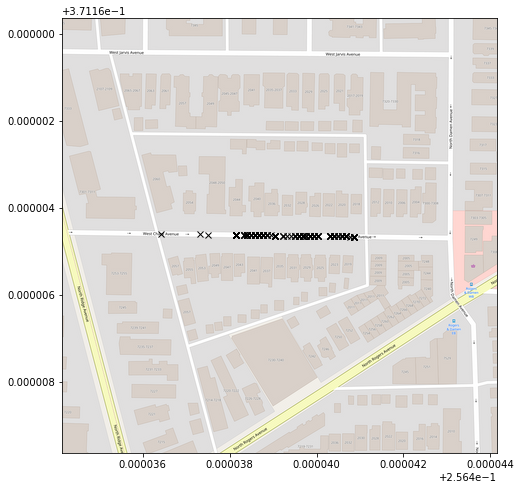

In [12]:
# 020XX W CHASE AVE
fig, ax = plt.subplots(figsize=(16,8))
plot_block(ax, "020XX W CHASE AVE")

Again with the outliers...  (From later analysis with the "old" dataset, this appears to be a genuine "outlier")

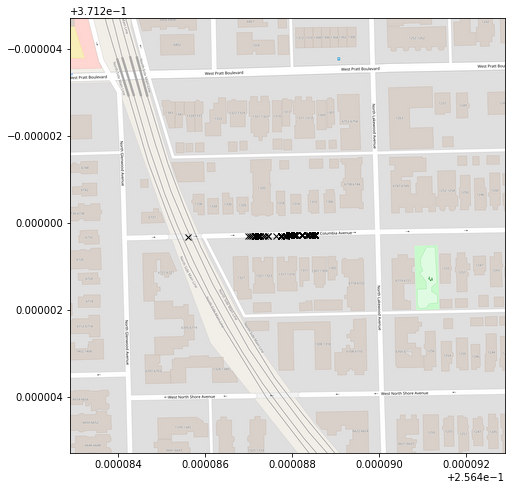

In [13]:
# 013XX W COLUMBIA AVE
fig, ax = plt.subplots(figsize=(16,8))
plot_block(ax, "013XX W COLUMBIA AVE")#, scatter_all=True)

More outliers.  Except that here, the bottom "point" is really a large cluster...

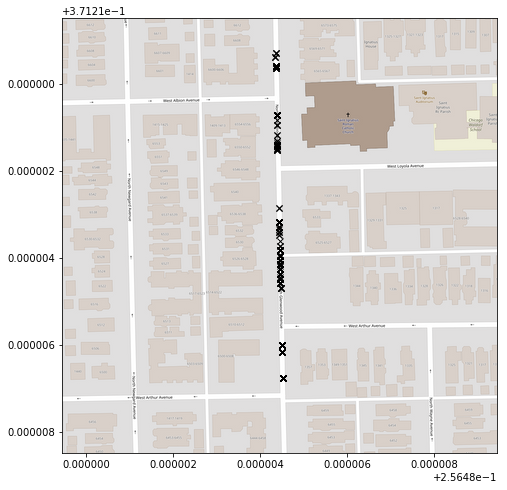

In [14]:
# 065XX N GLENWOOD AVE
fig, ax = plt.subplots(figsize=(16,8))
plot_block(ax, "065XX N GLENWOOD AVE")#, scatter_all=True)

# Dump to a shape-file

In [6]:
gframe = gpd.GeoDataFrame({"block" : frame.block})
gframe.geometry = [shapely.geometry.Point(x, y) for x, y in zip(frame.x, frame.y)]
gframe.crs = {"init":"epsg:4326"}
gframe.head()

,block,geometry
0,108XX S AVENUE G,POINT (-87.531655723 41.698387427)
1,060XX S WOLCOTT AVE,POINT (-87.67161153799999 41.784308275)
2,014XX E 74TH ST,POINT (-87.590369552 41.760550978)
3,006XX E 90TH PL,POINT (-87.608883201 41.730199189)
4,040XX N KIMBALL AVE,POINT (-87.712927149 41.9544026)


In [7]:
gframe.to_file("chicago_points")

# Compare to TIGER/Lines files

In [9]:
#tigerdir = os.path.join("..", "..", "..", "..", "Data", "TIGER Data")
tigerdir = os.path.join("/media", "disk", "TIGER Data")
tl = impute.tiger_lines.TigerLines(os.path.join(tigerdir, "tl_2016_17031_roads"),
                        os.path.join(tigerdir, "tl_2016_17031_edges"), proj)

In [10]:
tl.roads_graph.number_edges, tl.edges_graph.number_edges

(942922, 1137561)

In [11]:
tl.check_null_edges()
tl.name_in_roads_only

[(403281, 'Pct Line', {None})]

In [12]:
frame = tl.to_geodataframe()
frame.to_file("chicago_merged_edges")

In [13]:
frame = tl.to_reduced_geodataframe()
frame.to_file("chicago_merged_edges_reduced")

# Look at unique coordinates by block, and project to graph

For each block, we project the points associated with this block to the graph, and then report the address and name data for that edge.

Having looked at some example (interactively, in QGIS) we find that we get better performance by using the "reduced" graph.  That is, throw away edges with no name, or names which are obviously not roads.

Thoughts:

- A "perfect" match would be a block name like "079XX S PAXTON AVE" matching up only with edges from "S PAXTON AVE" where at least one side of the road had road numbers in the range 7900 to 7999
- This is too much to hope for; mostly because some edges don't have address information.
- There are also some variations in spelling.
- But mostly the match is very, very good.
- A few examples of a mismatch between the TIGER/Lines data and the points, leading to incorrect projections.  Hard to know what to do here: could consider "which edges are close to being closest", but then how do you decide which is the "correct" match?  I _think_ that for the Voroni based algorithm we'll use in the end, it doesn't actually matter that much.
- There are a few outliers, which would be good to investigate more systematically.

In [14]:
graph, reduced_edge_lookup = tl.make_reduced_graph()

## Save reduced graph

In [15]:
import bz2, pickle
with open("chicago_merged_graph.pic", "wb") as f:
    pickle.dump(graph.dump_bytes(), f)
    pickle.dump(bz2.compress(pickle.dumps(reduced_edge_lookup)), f)

## Look at `blocks`

Aggregate by block a list of all coordinates.

In [11]:
coords_by_block = collections.defaultdict(list)
for row in gen():
    if row.datetime.year > 2001:
        coords_by_block[row.address].append(row.point)
coords_by_block = {block : [proj(x,y) for x,y in pts] for block, pts in coords_by_block.items()}
coords_by_block = {block : collections.Counter(pts) for block, pts in coords_by_block.items()}
len(coords_by_block)

51625

Generate a CSV file which summarises this:
- For each block, look at each point associated with that block
- Projected to the graph
- Report all edges we get, and the "name" of that edge from the TIGER/Lines data

In [12]:
import csv
block_to_all_names = {}
with open("test.csv", "wt", newline="") as f:
    writer = csv.writer(f)
    for block, pts_count in list(coords_by_block.items()):
        edges = collections.defaultdict(int)
        for (x, y), count in pts_count.items():
            (v1, v2), t = graph.project_point_to_graph(x, y)
            e, _ = graph.find_edge(v1, v2)
            e = reduced_edge_lookup[e]
            edges[e] += count
        all_names = set()
        for edge, count in edges.items():
            row = [block, edge, count]
            address, all_names = tl.merged_names[edge]
            row += list(address)
            names = [x.upper() for x in all_names if x is not None]
            row += names
            writer.writerow(row)
            all_names.update(names)
        block_to_all_names[block] = all_names
        writer.writerow([])

## Outliers

Find "blocks" where the points seem really far apart.

Examples:
- `047XX S WENTWORTH AVE`  Single outlier, see no reason
- `059XX S CICERO AVE`  Couple of events coded to North Cicero Avenue.  No good reason (from the TIGER/Lines data) as to why.
- `106XX S WENTWORTH AVE`  Single outlier, see no reason
- `047XX S LAKE SHORE DR NB`  Single event coded to North Lake Shore Drive
- `070XX S LOWE AVE`  Single outlier, see no reason

And so on...

In [13]:
chicago = gpd.GeoDataFrame.from_file(os.path.join(datadir, "Chicago_Areas.geojson"))
chicago.crs = {"init":"epsg:4326"}
chicago = chicago.to_crs({"init":"epsg:2790"}).geometry.unary_union

In [27]:
max_dist = {}
for block, pts_count in coords_by_block.items():
    pts = np.asarray(list(pts_count))
    if pts.shape[0] < 2:
        max_dist[block] = 0.0
    else:
        m = scipy.spatial.distance.pdist(pts)
        max_dist[block] = np.max(m)
dists = list(max_dist.items())

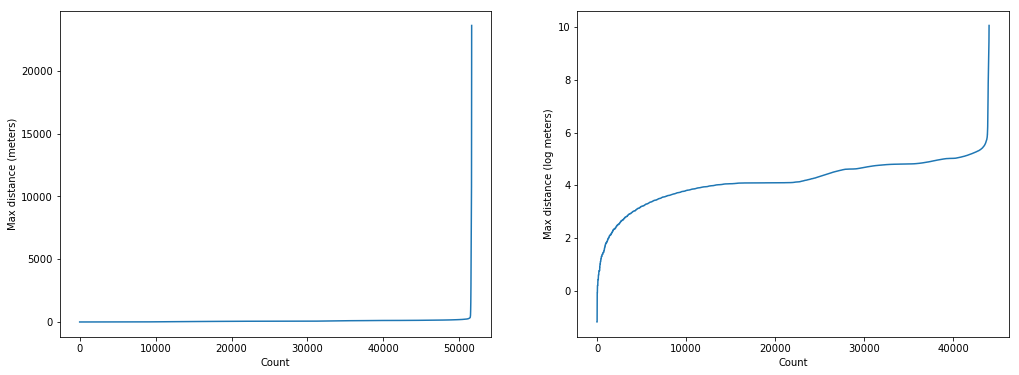

In [28]:
dists.sort(key=lambda p : p[1])
fig, ax = plt.subplots(ncols=2, figsize=(17,6))
ax[0].plot([p[1] for p in dists])
ax[0].set(xlabel="Count", ylabel="Max distance (meters)")
ax[1].plot(np.log([p[1] for p in dists if p[1]>0]))
ax[1].set(xlabel="Count", ylabel="Max distance (log meters)")
None

In [16]:
block, _ = dists[-7]
block

'070XX S LOWE AVE'

In [17]:
pts_count = coords_by_block[block]
edges = collections.defaultdict(int)
for (x, y), count in pts_count.items():
    (v1, v2), t = graph.project_point_to_graph(x, y)
    e, _ = graph.find_edge(v1, v2)
    e = reduced_edge_lookup[e]
    edges[e] += count
for edge, count in edges.items():
    address, all_names = tl.merged_names[edge]
    names = [x.upper() for x in all_names if x is not None]
    print(edge, count, names)

730560 195 ['S LOWE AVE', 'S LOWE AVE']
1121677 1 ['N LATROBE AVE', 'N LATROBE AVE']


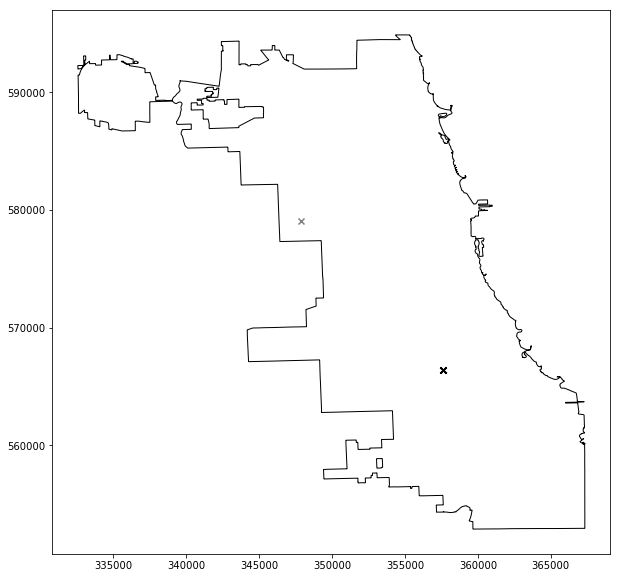

In [18]:
fig, ax = plt.subplots(figsize=(10,10))

ax.add_patch(descartes.PolygonPatch(chicago, fc="none"))
pts = np.asarray(list(coords_by_block[block].keys()))
ax.scatter(*pts.T, marker="x", color="black", alpha=0.5)

# Automate

We use some clustering tools to automatically look at "blocks" which span a very large area.  These can be classified into:

- What seem like genuine "errors": single events, or 2 events, geo-coded to the wrong place
- The airport, where a very large geographic area has the same address
- A small number of cases where the East/West (or North/South) parts of the same street have been confused.

I find these errors (singletons, or more systematic) very hard to explain.  I would imagine that the data is collected by _one of_ an entry of the address (perhaps a lookup into a database) or capturing GPS coordinates.  Then other other data would be automatically filled in, by geo-coding, or reverse geo-coding.  It is not clear to me how the two bits of data can become misaligned.
- On the one hand, the singleton errors seem mostly (from a random sample I looked at) to be without pattern.
- The East/West errors look systematic, like human fault, but at what point would someone manually enter the address _while the coordinates stay the same_?

Anyway, out of the whole database, these errors are a tiny, tiny fraction.

In [87]:
import scipy.cluster.vq

def cluster(pts):
    centroids,_ = scipy.cluster.vq.kmeans(pts, 2)
    idx,_ = scipy.cluster.vq.vq(pts, centroids)
    out = []
    for i in range(2):
        points = pts[idx == i]
        dists = scipy.spatial.distance.pdist(points)
        md = 0 if len(dists) == 0 else np.max(dists)
        out.append((md, len(points)))
    return out

small_error_count = 0
for block, md in dists[::-1]:
    if md < 600:
        continue
    pts = np.asarray(list(coords_by_block[block]))
    cl = cluster(pts)
    if (0,1) in cl:
        small_error_count += 1
        continue
    if block.endswith(" W OHARE ST"): # Airport
        continue
    if any(x==2 for _,x in cl):
        small_error_count += 1
        continue
    print(block, cl)
small_error_count

025XX E 71ST ST [(114.0153993650944, 12), (104.59101439103499, 5)]
008XX E 87TH ST [(64.747051926837173, 10), (228.06439986207994, 41)]
007XX E 87TH ST [(158.3758217853474, 20), (149.40490580648398, 29)]
006XX E 87TH ST [(121.05229931413101, 21), (135.23295604642036, 17)]
005XX E 87TH ST [(136.19676016481108, 18), (116.1774813359025, 35)]
004XX E 87TH ST [(82.503663324520446, 20), (130.5059420425579, 39)]
028XX N MILWAUKEE AVE [(1251.6326177356302, 33), (177.98403223887956, 37)]
003XX N SANGAMON ST [(70.74587904337649, 10), (15.55674351855111, 3)]
003XX N PEORIA ST [(28.970564719054252, 11), (32.626512275272248, 4)]
0000X W 69TH ST [(119.82547013264531, 17), (708.53692609984932, 23)]
037XX W 79TH ST [(129.67503905653845, 17), (565.61881631680035, 27)]
001XX W WASHINGTON ST [(622.59694486352373, 14), (62.487084004979437, 13)]
016XX N ELSTON AVE [(583.46592117765658, 20), (57.73051657877663, 18)]
023XX S PULASKI RD [(664.69353740153679, 16), (17.688921836331016, 18)]
001XX E 111TH ST [(8

129

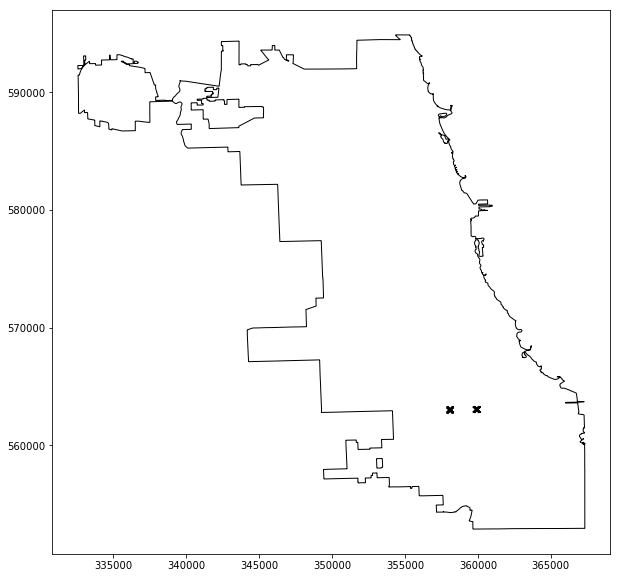

In [86]:
block = "004XX E 87TH ST"
fig, ax = plt.subplots(figsize=(10,10))
ax.add_patch(descartes.PolygonPatch(chicago, fc="none"))
pts = np.asarray(list(coords_by_block[block].keys()))
ax.scatter(*pts.T, marker="x", color="black", alpha=0.5)

In [81]:
pts_count = coords_by_block[block]
edges = collections.defaultdict(int)
for (x, y), count in pts_count.items():
    (v1, v2), t = graph.project_point_to_graph(x, y)
    e, _ = graph.find_edge(v1, v2)
    e = reduced_edge_lookup[e]
    edges[e] += count
for edge, count in edges.items():
    address, all_names = tl.merged_names[edge]
    names = [x.upper() for x in all_names if x is not None]
    print(edge, count, set(names))

989998 34 {'S BLUE ISLAND AVE'}
411499 80 {'S BLUE ISLAND AVE'}
703960 164 {'S BLUE ISLAND AVE'}
989997 29 {'S BLUE ISLAND AVE'}
310231 58 {'S BLUE ISLAND AVE'}
138171 5 {'S BLUE ISLAND AVE'}
310232 4 {'S BLUE ISLAND AVE'}
989996 19 {'S BLUE ISLAND AVE'}
